<a href="https://colab.research.google.com/github/juampismon/IAHR24_LISBON/blob/main/02_Slope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing the notebook's environment

### Import and install required libraries

In [1]:
# Import the libraries already installed in the Colab virtual machine.
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import dask.array as da
import math
import tarfile
import gc  # Importing garbage collector module
from shapely.geometry import box as shapely_box

In [2]:
# Install the libraries NOT installed in the Colab virtual machine.
!pip install pyogrio
!pip install OWSLib
!pip install rasterio
!pip install richdem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844535 sha256=a1694d54bfbd65bb4d5296959218e741ecc43d302a416b7ddc18230f3802d116
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116b5cffecf04ed75c40f640e2baf231dae20954e31e0
Successfully built richdem


In [3]:
# Import the recently installed libraries

from owslib.wcs import WebCoverageService #SoilGrids
import rasterio
import rasterio.plot as rasplot
import rasterio.merge as rasmerge

import richdem as rd # Slope map

### Install the hda module and set up the HDA Client

In [4]:
# Install the latest version of hda
!pip install hda -U

  Preparing metadata (setup.py) ... done
  Created wheel for hda: filename=hda-2.14-py3-none-any.whl size=15156 sha256=907aa9557eafeab93ff833b76a915308facff8d1d5f8bfe62309fd3bf961cd76
  Stored in directory: /root/.cache/pip/wheels/f0/b9/9c/ebfae7fbd338f77aa889fa40cc39d21b0eb5360d564356b08e
Successfully built hda


In [5]:
# Import the needed functions from the hda module
from hda import Client, Configuration

# Configure credentials and load hda Client
### Create the .hdarc configuration file as follows:
from pathlib import Path

# Default location expected by hda package
hdarc = Path(Path.home() / '.hdarc')

# Create or re-write the .hdarc file
import getpass
USERNAME = input('Enter your username: ')
PASSWORD = getpass.getpass('Enter your password: ')

with open(Path.home() / '.hdarc', 'w') as f:
  f.write(f'user:{USERNAME}\n')
  f.write(f'password:{PASSWORD}\n')

### Load the hda client using the default .hdarc file for getting your credentials
hda_client = Client()

Enter your username: garciamonjp
Enter your password: ··········


### Create a connection to your Drive

In [6]:
from google.colab import drive
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download from Drive the Geopackages created in the previous session and select basins.

Download from Drive the `Iberia_Affected_basins_CLC_CHA_1218.gpkg` geopackage created in the previous session and select basins with an absolute HAV bigger than 1.

In [7]:

IP_affected_basins_path = '/content/drive/MyDrive/Iberia_project/03_Results/Iberia_Affected_basins_CLC_CHA_1218.gpkg'
# Read files using GeoPandas
IP_affected_basins_gdf = gpd.read_file(IP_affected_basins_path, layer='Affected_subbasins', engine= 'pyogrio', use_arrow=True) ## < 20 s

IP_Selected_basins = IP_affected_basins_gdf.loc[IP_affected_basins_gdf['HAV'].abs() > 1, ['Basin_ID', 'geometry']]


# Show result
IP_Selected_basins

,Basin_ID,geometry
1,Duer100003,"MULTIPOLYGON (((3032153.334 2053840.916, 30321..."
6,Duer100050,"MULTIPOLYGON (((2765050.000 2198325.000, 27649..."
30,Duer100194,"MULTIPOLYGON (((2779425.000 2364675.000, 27794..."
33,Duer100207,"MULTIPOLYGON (((2794300.000 2366775.000, 27941..."
39,Duer100231,"MULTIPOLYGON (((3136440.595 2371987.346, 31364..."
...,...,...
10679,Tajo107523,"MULTIPOLYGON (((2676375.000 2025650.000, 26763..."
10706,Tajo107567,"MULTIPOLYGON (((3008684.281 2037836.251, 30085..."
10707,Tajo107574,"MULTIPOLYGON (((2905900.000 2062944.326, 29059..."
10709,Tajo107580,"MULTIPOLYGON (((2864897.709 2104675.000, 28649..."


In [8]:
del IP_affected_basins_gdf

<Axes: >

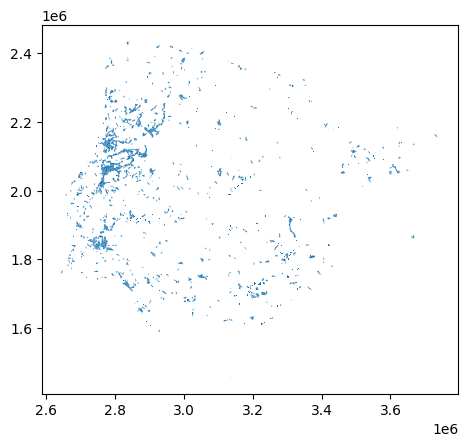

In [9]:
IP_Selected_basins.plot()

### Download DEM data

14
9
 total quandrants: 126


quandrants with basins: 80


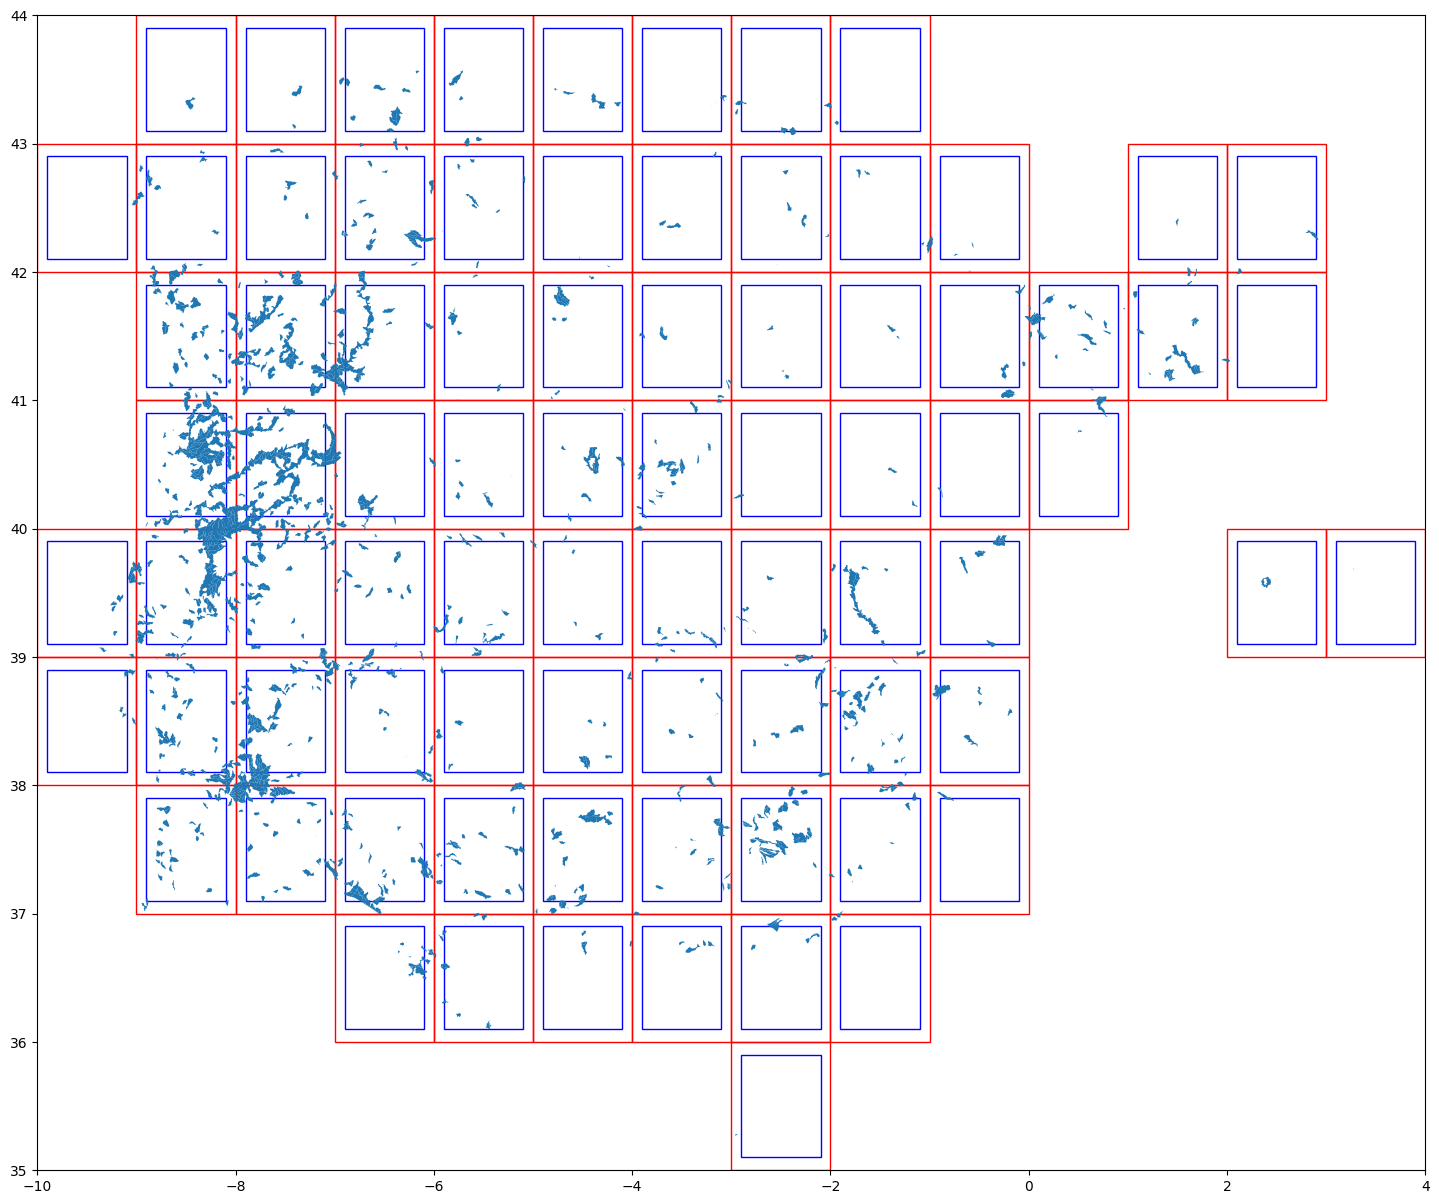

In [10]:


# Create a plot
fig, ax = plt.subplots(figsize=(20, 15))


# Convert CRS to WGS 84 (EPSG:4326)
gdf_wgs84 = IP_Selected_basins.to_crs(epsg=4326)


# Get the bounds of the selected area
minx, miny, maxx, maxy = gdf_wgs84.total_bounds

# Transform to the near integer (floor for min and ceil for max)
minx = math.floor(minx)
miny = math.floor(miny)
maxx = math.ceil(maxx)
maxy = math.ceil(maxy)



# Calculate the number of columns and rows based on 1º x 1º quadrants
num_cols = maxx - minx
num_rows = maxy - miny


print(num_cols)
print(num_rows)
print(' total quandrants:', str(num_cols * num_rows ))

# Initialize a list to store the quadrant coordinates
quadrants = []
# Initialize a list to store the polygons
polygons = [] # Search bounding boxes

c = 0
for i in range(num_rows):
  for j in range(num_cols):
    xmin = minx + j
    xmax = minx + (j + 1)
    ymin = miny + i
    ymax = miny + (i + 1)

    #quad_bbox = tuple(xmin, ymin, xmax, ymax)
    quad_basins = gdf_wgs84.iloc[gdf_wgs84.sindex.query(shapely_box(xmin, ymin, xmax, ymax))]
    # Skip this quadrant if there are not basin in it
    if quad_basins.empty:
      quadrants.append([xmin, ymin, xmax, ymax, False])
      continue
    quadrants.append([xmin, ymin, xmax, ymax, True])
    rect_quad = plt.Rectangle((xmin, ymin), (xmax - xmin), (ymax  - ymin), edgecolor='r', facecolor='none')
    ax.add_patch(rect_quad)
    rect_searchbox = plt.Rectangle((xmin + 0.1, ymin + 0.1), (xmax - xmin - 0.2), (ymax  - ymin - 0.2), edgecolor='b', facecolor='none')
    ax.add_patch(rect_searchbox)
    query = {
        "datasetId": "EO:DEM:DAT:COP-DEM_GLO-90-DGED__2023_1",
        "boundingBoxValues": [
            {
                "name": "bbox",
                "bbox": [
                    xmin + 0.1,  # West
                    ymin + 0.1,  # South
                    xmax - 0.1,  # East
                    ymax - 0.1  # North
                    ]
            }
        ]
      }
    # Configure the client not to show download progress
    hda_client_NP = Client(progress=False)
    # Ask and check the results for the query
    matches = hda_client_NP.search(query)
    # Download
    matches.download(download_dir="./temp/DEM")





gdf_wgs84.plot(ax=ax)
# Set plot limits
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# Convert the list of lists into a DataFrame
quad_df = pd.DataFrame(quadrants, columns=['minx', 'miny', 'maxx', 'maxy', 'basins_within'])
print('quandrants with basins:', quad_df['basins_within'].sum())
# Show the plot
plt.show()

10 minutes!!!!!

### Merge the tiles for the zone of interest (i.e. Iberian Peninsula)

In [11]:
# Define the folder containing the .tar files
folder_path = '/content/temp/DEM/'

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tar'):
        tar_path = os.path.join(folder_path, filename)

        # Extract files from the .tar archive
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path='/content/temp/COP_DEM/')

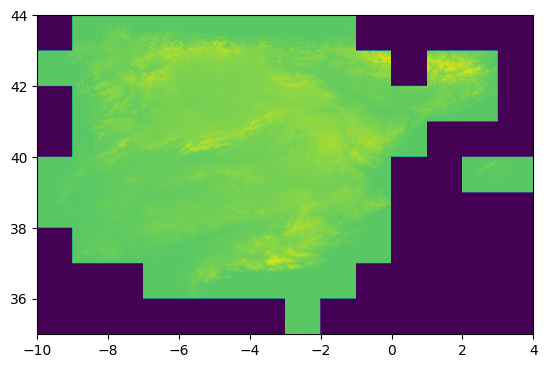

45

In [12]:
# List of paths to raster files
tile_paths = []

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for cell_name in os.listdir('/content/temp/COP_DEM/'):
    file_path = '/content/temp/COP_DEM/'+cell_name+'/DEM/'+cell_name+'_DEM.tif'
    tile_paths.append(file_path)

# Open each tile and store them in a list
src_files_to_mosaic = []
for tile_path in tile_paths:
    src = rasterio.open(tile_path)
    src_files_to_mosaic.append(src)

# Merge the tiles together
mosaic, out_trans = rasmerge.merge(src_files_to_mosaic, nodata=-9999)

# Get the metadata of one of the tiles (assuming both tiles have the same metadata)
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

# Save the merged raster map
output_path = '/content/temp/merged_map.tif'
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic)

# Plot the merged raster map
with rasterio.open(output_path) as merged_src:
    rasplot.show(merged_src)

# Clean up memory
for src in src_files_to_mosaic:
    src.close()

merged_src.close()
dest.close()
gc.collect()

### Reproject to EPSG:3035

In [13]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
# Path to the input raster file (EPSG:4326)
input_raster_path = '/content/temp/merged_map.tif'

# Path to the output raster file (EPSG:3035)
output_raster_path = '/content/temp/merged_map_LAEA_Europe.tif'

# Define the target CRS (EPSG:3035)
target_crs = 'EPSG:3035'

# Open the input raster file
with rasterio.open(input_raster_path) as src:
    # Calculate the transform for reprojecting
    transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
    # Update metadata for the output raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create the output raster file
    with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
        # Reproject the input raster to EPSG:3035
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            src_nodata=-9999,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
            dst_nodata=-9999
        )

    # Print CRS information
    print(src.crs)
    print(dst.crs)

# Clean up memory
gc.collect()


EPSG:4326
EPSG:3035


0

In [14]:
# Path to the reprojected raster file (EPSG:3035)
raster_path = '/content/temp/merged_map_LAEA_Europe.tif'
# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Assuming the raster has only one band

    # Get the maximum value
    max_value = raster_data.max()
    # Get the maximum value
    min_value = raster_data.min()

print("Maximum value:", max_value)
print("Min value:", min_value)

# Clean up memory
del raster_data
gc.collect()

Maximum value: 3459.856
Min value: -9999.0


0

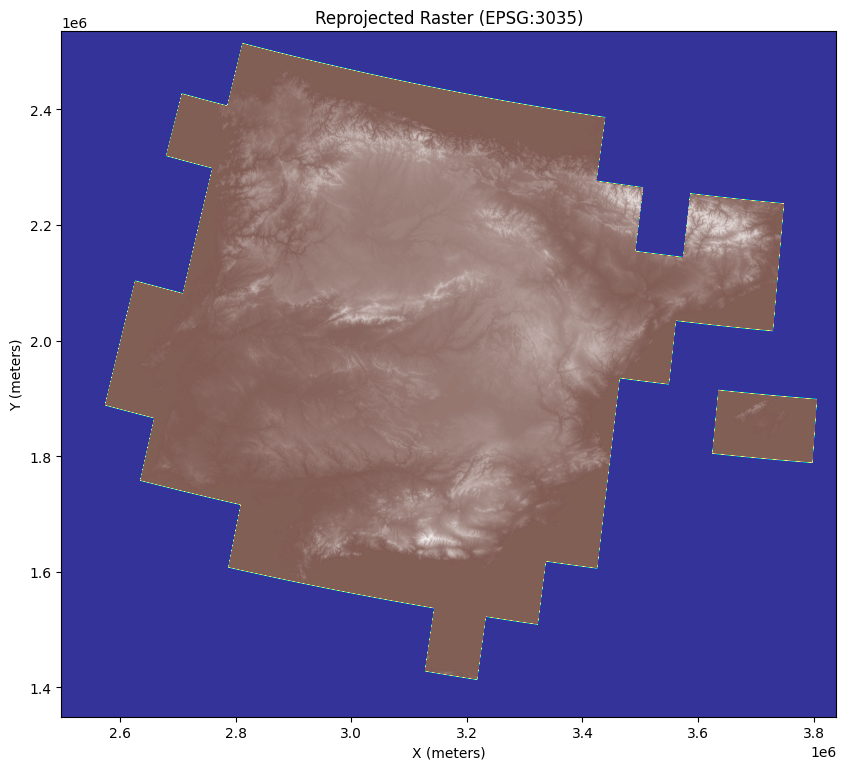

3438

In [15]:
# Path to the reprojected raster file (EPSG:3035)
reprojected_raster_path = '/content/temp/merged_map_LAEA_Europe.tif'

# Open the reprojected raster file
with rasterio.open(reprojected_raster_path) as mdt_zona:
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 10))
    rasplot.show(mdt_zona, ax=ax, title='MDT, 90 m', cmap='terrain')
    plt.title('Reprojected Raster (EPSG:3035)')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.show()

# Clean up memory
mdt_zona.close()
gc.collect()

### Generate the slope map with the richdem library

In [16]:
# Path to the reprojected raster file (EPSG:3035)
reprojected_raster_path = '/content/temp/merged_map_LAEA_Europe.tif'

# Load the raster data using richdem
dem = rd.LoadGDAL(reprojected_raster_path, no_data=-9999)

# Compute slope using richdem
slp = rd.TerrainAttribute(dem, attrib="slope_percentage")

# Save the slope map
rd.SaveGDAL("slope_unmasked.tif", slp)

# Clean up memory
del dem
del slp
gc.collect()

44

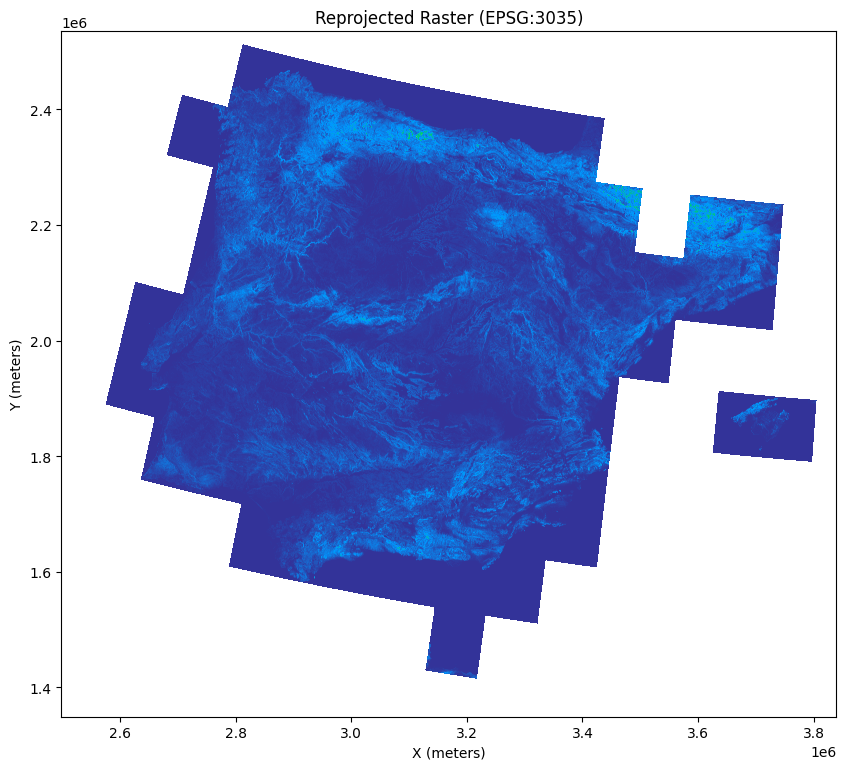

3448

In [17]:
# Path to the reprojected raster file (EPSG:3035)
reprojected_raster_path = '/content/slope_unmasked.tif'

# Open the reprojected raster file
mdt_zona = rasterio.open(reprojected_raster_path)

# Plot the raster
fig, ax = plt.subplots(figsize=(10, 10))
rasplot.show(mdt_zona, ax=ax, title='MDT, 90 m', cmap='terrain')
plt.title('Reprojected Raster (EPSG:3035)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.show()

# Close the rasterio dataset
mdt_zona.close()

# Clean up memory
gc.collect()

### Build the reclassified slope map
- Slope $>= 3$ %: 1000
- Slope $< 3$ %: 2000

In [18]:
# Import the basin slope map
raster_path = "slope_unmasked.tif"

# Open the raster file using rasterio
with rasterio.open(raster_path) as slope_qnk:
    # Read the raster data as a Dask array
    slope_qnk_np = da.from_array(slope_qnk.read(1), chunks='auto')

    # Reclassify the data
    slope_reclass = da.where((slope_qnk_np >= 3), 1000, 2000)
    min_value = da.min(slope_qnk_np)
    slope_reclass = da.where((slope_qnk_np == min_value), min_value, slope_reclass)

    # Copy the metadata from the basin slope map
    metadata = slope_qnk.meta.copy()

    # Write the reclassified data to the new GeoTIFF file
    with rasterio.open('slope_reclass.tif', 'w', **metadata) as dst:
        dst.write(slope_reclass.astype(metadata['dtype']), 1)

# Clean up memory
gc.collect()

0

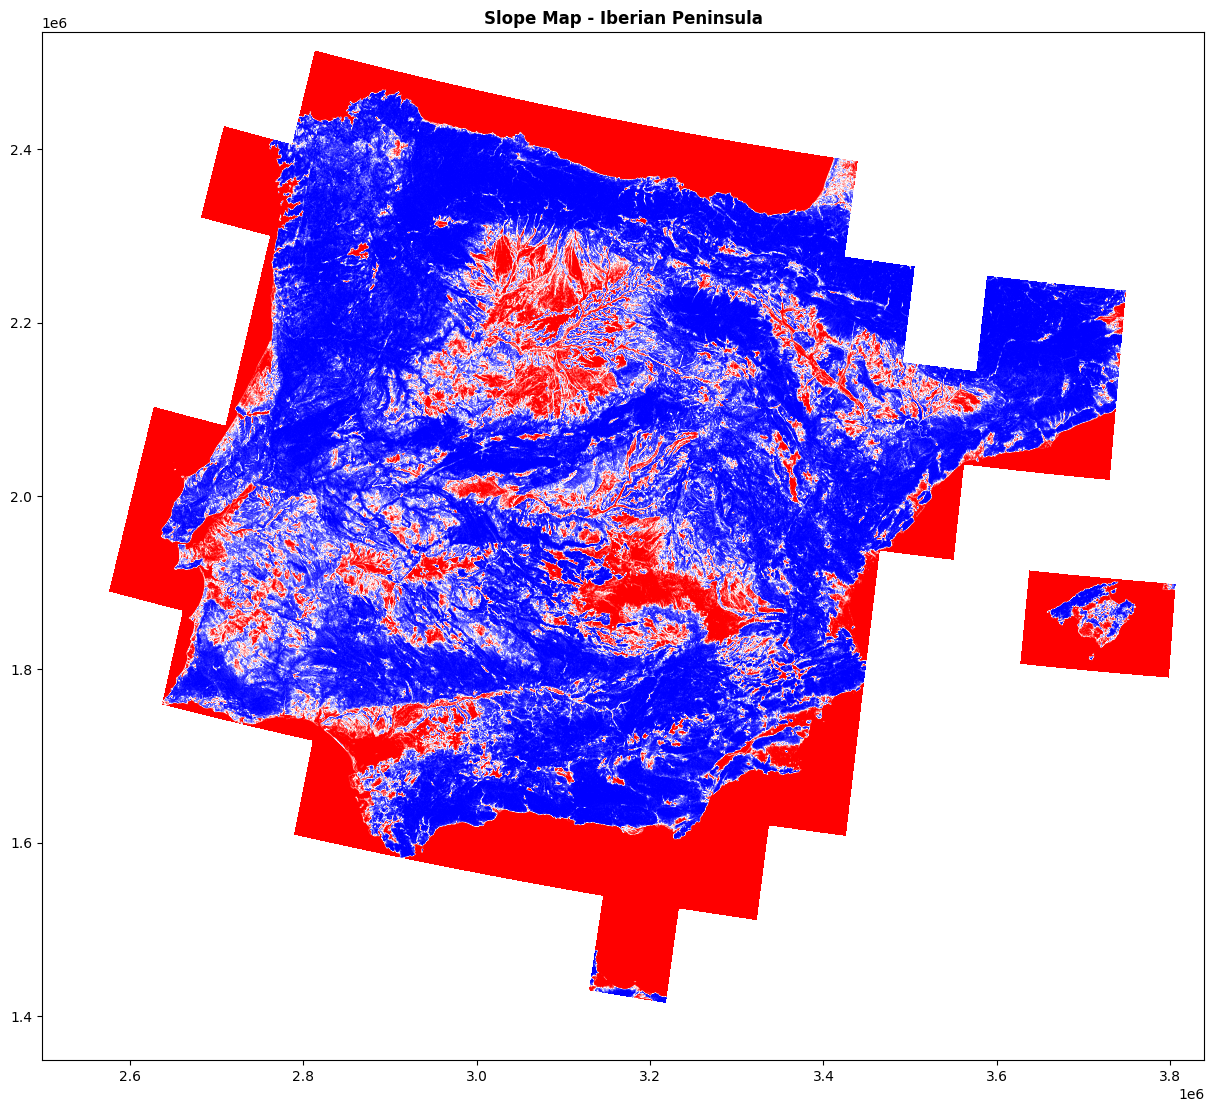

3403

In [20]:
# Import the reclassified slope map
raster_path = "slope_reclass.tif"

# Open the raster file
slope_qnk = rasterio.open(raster_path)

# Plot to visualize
fig, ax = plt.subplots(figsize=(15, 15))
rasplot.show(slope_qnk, ax=ax, title='Slope Map - Iberian Peninsula', cmap='bwr')
plt.show()

# Close the rasterio dataset
slope_qnk.close()

# Clean up memory
gc.collect()

# SAVE A COPY TO DRIVE

In [21]:
# Copy the file to Google Drive
!cp /content/slope_reclass.tif /content/drive/MyDrive/Iberia_project/03_Results

---

> The following part of the module stands for a bit more detailed explanation of the Hydrologic Soil groups function we are going to use in the next notebook.

# Soil groups

In [ ]:
import pyproj # CRS
from os.path import join as opj
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.patches import Patch

In [ ]:
# Reproject to the spatial reference system used by the Soilgrids maps.
wkt_string = (
    'PROJCS["Homolosine", '
    'GEOGCS["WGS 84", '
    'DATUM["WGS_1984", '
    'SPHEROID["WGS 84",6378137,298.257223563, '
    'AUTHORITY["EPSG","7030"]], '
    'AUTHORITY["EPSG","6326"]], '
    'PRIMEM["Greenwich",0, '
    'AUTHORITY["EPSG","8901"]], '
    'UNIT["degree",0.0174532925199433, '
    'AUTHORITY["EPSG","9122"]], '
    'AUTHORITY["EPSG","4326"]], '
    'PROJECTION["Interrupted_Goode_Homolosine"], '
    'UNIT["Meter",1]]'
)
crs_soils = pyproj.CRS.from_string(wkt_string)
qnk_holo = quad_with_basin.to_crs(crs_soils)
qnk_holo.crs

<Projected CRS: PROJCS["Homolosine", GEOGCS["WGS 84", DATUM["WGS_1 ...>
Name: Homolosine
Axis Info [cartesian]:
- E[east]: Easting (Meter)
- N[north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# The minimum and maximum basin coordinates (i.e. the coordinates defining the extent of the basin) are extracted.
qnk_coords = qnk_holo['geometry']
qnk_coords = qnk_coords.bounds
qnk_coords

,minx,miny,maxx,maxy
1338,608512.801110,4.816988e+06,609528.508084,4.817809e+06
1339,613529.810814,4.819553e+06,613843.528946,4.820956e+06
20,617667.824019,4.821615e+06,623664.177499,4.826712e+06


In [ ]:
# The minimum and maximum basin coordinates (i.e. the coordinates defining the extent of the basin) are extracted.
qnk_coords = qnk_holo['geometry']
qnk_coords = qnk_coords.total_bounds
qnk_coords

array([ 608512.8011105 , 4816988.19900797,  623664.17749855,
       4826712.20592534])

### Download the maps with the clay, sand and silt content from the _SoilGrids_ Collection Web Service
___[SoilGrids](https://www.isric.org/explore/soilgrids/faq-soilgrids/)___  is a collection of soil property maps for the world produced using machine learning at 250 m resolution.



In [ ]:
# Define the clipping extension
exten = [('X', qnk_coords[0] - 1000, qnk_coords[2] + 1000), ('Y', qnk_coords[1] - 10000, qnk_coords[3] + 1000)]
# Define the CRS in which the information will be downloaded.
crs_V2 = "http://www.opengis.net/def/crs/EPSG/0/152160"# CRSs refers to the opengis.net registry.

---
__Note:__ It is possible to download the maps directly in `EPSG:4326`. Nevertheless, [it is advised to avoid its use when working with SoilGrids products](https://gis.stackexchange.com/questions/387025/how-can-i-download-soilgrids-v2-data-through-wcs-in-epsg4326-keeping-as-close).

In [ ]:
# Create a directory to store the downloaded information
!mkdir soils
# Download the layers up to 1 m
capas = ['clay', 'sand', 'silt']
file_names = []
for capa in capas:
    wcs_path = ''.join(['https://maps.isric.org/mapserv?map=/map/', capa,'.map'])
    wcs = WebCoverageService(wcs_path, version='2.0.1')
    names = [k for k in wcs.contents.keys() if k.endswith("mean")]
    i = 0
    for name in names[0:-1]:
        c_metadata = wcs.contents[name]
        response = wcs.getCoverage(identifier=[name], crs=crs_V2, subsets=exten, resx=250, resy=250, format=c_metadata.supportedFormats[0])
        file_name = ''.join([name, '.tif'])
        file_path = ''.join(['./soils/',file_name])
        with open(opj(file_path), 'wb') as file:
            file.write(response.read())
        file_names.append(file_name)
        print(''.join([file_name, ' has been successfully downloaded']))

mkdir: cannot create directory ‘soils’: File exists
clay_0-5cm_mean.tif has been successfully downloaded
clay_5-15cm_mean.tif has been successfully downloaded
clay_15-30cm_mean.tif has been successfully downloaded
clay_30-60cm_mean.tif has been successfully downloaded
clay_60-100cm_mean.tif has been successfully downloaded
sand_0-5cm_mean.tif has been successfully downloaded
sand_5-15cm_mean.tif has been successfully downloaded
sand_15-30cm_mean.tif has been successfully downloaded
sand_30-60cm_mean.tif has been successfully downloaded
sand_60-100cm_mean.tif has been successfully downloaded
silt_0-5cm_mean.tif has been successfully downloaded
silt_5-15cm_mean.tif has been successfully downloaded
silt_15-30cm_mean.tif has been successfully downloaded
silt_30-60cm_mean.tif has been successfully downloaded
silt_60-100cm_mean.tif has been successfully downloaded


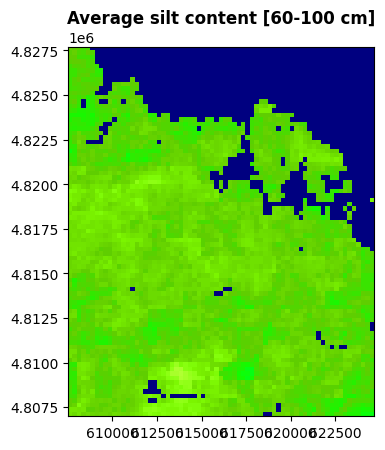

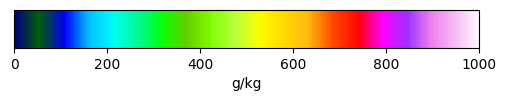

In [ ]:
### Plot to visualise the result
silt_ras= rasterio.open(opj(file_path), driver="GTiff")

rasplot.show(silt_ras, title='Average silt content [60-100 cm]', cmap='gist_ncar', vmin=0, vmax=1000);

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=0, vmax=1000)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='gist_ncar'),
             cax=ax, orientation='horizontal', label='g/kg');

### We do the weighted average for each layer according to its depth.

In [ ]:
# The variables needed to read and operate the raster are initialised.
file_path = ''.join(['./soils/', file_names[-1]])
silt_ras= rasterio.open(opj(file_path), driver="GTiff")
silt_num = silt_ras.read(1)
ipath = "./soils/"
peso = [5, 10, 15, 30, 40]
k_clay = 0
k_sand = 0
k_silt = 0
clay = np.zeros(silt_num.shape)
sand = np.zeros(silt_num.shape)
silt = np.zeros(silt_num.shape)
# We make a loop that operates all the raster we have downloaded in the soils folder.
for file_name in file_names:
    #print(file_name) # Print to verify the order of execution
    if file_name.startswith('clay'):
        capa_path = ''.join([ipath, file_name])
        capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
        clay = clay + capa_ras.read(1) * peso[k_clay] / 1000
        k_clay = k_clay + 1
    elif file_name.startswith('sand'):
        capa_path = ''.join([ipath, file_name])
        capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
        sand = sand + capa_ras.read(1) * peso[k_sand] / 1000
        k_sand = k_sand + 1
    elif file_name.startswith('silt'):
        capa_path = ''.join([ipath, file_name])
        capa_ras = rasterio.open(opj(capa_path), driver="GTiff")
        silt = silt + capa_ras.read(1) * peso[k_silt] / 1000
        k_silt = k_silt + 1
# We print to check
suma = clay + sand + silt
print(suma.max())
print(suma.min())
suma

100.095
0.0


array([[100.095, 100.   , 100.   , ...,   0.   ,   0.   ,   0.   ],
       [100.   ,  99.995, 100.03 , ...,   0.   ,   0.   ,   0.   ],
       [100.   ,  99.99 , 100.015, ...,   0.   ,   0.   ,   0.   ],
       ...,
       [100.   , 100.   , 100.035, ..., 100.   ,  99.96 ,  99.96 ],
       [100.045,  99.995, 100.   , ..., 100.015, 100.   , 100.005],
       [100.01 , 100.   ,  99.985, ...,  99.985, 100.   , 100.005]])

In [ ]:
!pip install stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24283 sha256=c8f744fd613d1cbeccd2afb9fcf90b77ab1f01257bcca7c397d5705f981781a9
  Stored in directory: /root/.cache/pip/wheels/c9/85/bc/3371b9bce1e4f7b8b638e8c968a4dbd74db171ee180c48f808
Successfully built stats


### We classify soils according to their average clay, sand and silt content.

The USDA texture shall be determined according to the Soil Textural Triangle (See bellow).

---
An integer shall be assigned for each classification, as follows:

    # Clay: 1.
    # Clay loam: 2.
    # Loam: 3.
    # Loamy sand: 4.
    # Sand: 5.
    # Sandy clay: 6.
    # Sandy clay loam: 7.
    # Sandy loam: 8.
    # Silt: 9
    # Silty clay: 10.
    # Silty clay loam: 11.
    # Silt loam: 12.
    # No data / Water surface: 0.

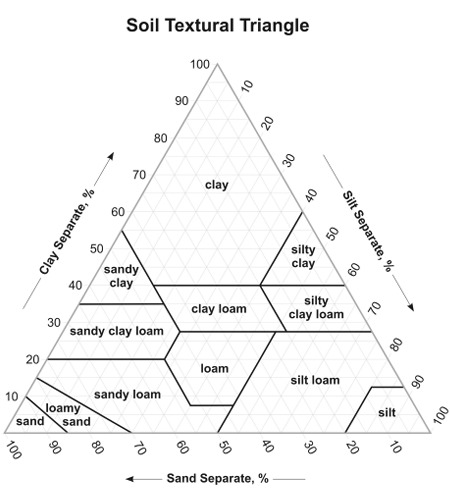

In [ ]:
# We create an array with the values assigned to each classification.
no_data_value = 0
texture = np.zeros(clay.shape)
texture[(clay >= 55) & (sand <= 45) & (silt < 40)] = 1 # Clay
texture[(clay >= 27) & (clay < 40) & (sand > 20) & (sand <= 45)] = 2 #  Clay loam
texture[(clay >= 7) & (clay < 27) & (silt >= 28) & (silt < 50) & (sand < 52)] = 3 # Loam
texture[((silt + 1.5 * clay) >= 15) & ((silt + 2* clay) < 30)] = 4 # Loamy sand
texture[((silt + 1.5 * clay) < 15)] = 5 # Sand
texture[(clay >= 35 )& (sand > 45)] = 6  # Sandy clay
texture[(clay >= 20) & (clay < 35) & (silt < 28) & (sand > 45)] = 7 # Sandy clay loam
texture[((clay >= 7) & (clay < 20) & (sand > 52) & ((silt+2*clay) >= 30)) | ((clay < 7) & (silt < 50) & ((silt+2*clay >= 30)))] = 8 # Sandy loam
texture[(silt >= 80) & (clay < 12)] = 9 # Silt
texture[(clay >= 40) & (silt >= 40)] = 10 # Silty clay
texture[(clay >= 27) & (clay < 40) & (sand <= 20)] = 11 # Silty clay loam
texture[((silt >= 50) & (clay >= 12) & (clay < 27)) | ((silt >= 50) & (silt < 80) & (clay < 12))] = 12 # Silt loam
texture[(sand == no_data_value) | (silt == no_data_value) | (clay == no_data_value)] = 0 # NO DATA / Water surface
texture

array([[2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       [2., 2., 2., ..., 0., 0., 0.],
       ...,
       [2., 2., 3., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [ ]:
# The variables needed to read and operate the raster are initialised.
opath = "./soils/USDAtextures.tif"
ipath = "./soils/clay_0-5cm_mean.tif"

with rasterio.open(opj(ipath)) as src:
    metadata =  src.meta.copy()
with rasterio.open(opath, 'w', **metadata) as dst:
    # Write the data to the new GeoTIFF file
    dst.write(texture, 1)
src.close()
dst.close()
print(''.join(['File created: ', opath]))

File created: ./soils/USDAtextures.tif


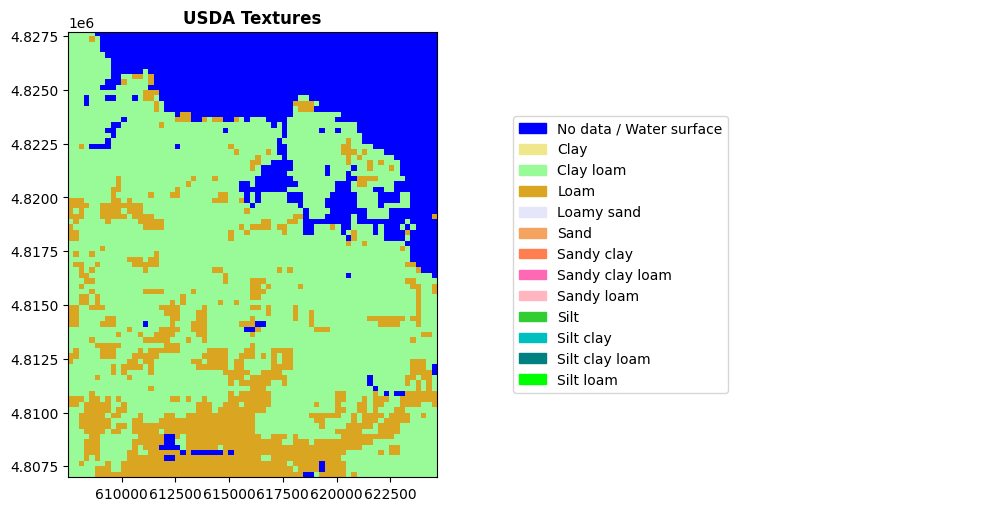

In [ ]:
# Open the raster file
raster_path =  "./soils/USDAtextures.tif"
src = rasterio.open(raster_path)
# Define your custom colormap with 12 colors
colors = ['blue', 'khaki', 'palegreen', 'goldenrod', 'lavender', 'sandybrown', 'coral', 'hotpink', 'lightpink', 'limegreen', 'c', 'teal', 'lime']
cmap = ListedColormap(colors, name='custom_colormap', N=13)


    # Plot the raster using rasterio's show function with the custom colormap
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    # Add a colorbar for the raster values
ax_1 =  axes[0]
ax_1 = rasplot.show(src, ax=ax_1, title='USDA Textures', cmap=cmap, vmin=0, vmax=13);

ax_2 =  axes[1]
ax_2.axis('off')
    # Create a legend for the classes
legend_labels = ['No data / Water surface', 'Clay', 'Clay loam', 'Loam', 'Loamy sand', 'Sand', 'Sandy clay',
                 'Sandy clay loam', 'Sandy loam', 'Silt', 'Silt clay', 'Silt clay loam', 'Silt loam']
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax_2.legend(handles=legend_patches, loc='center left')
    # Show the plot
plt.show()
src.close()

### Classify according to the hydrological group
For the purpose of this practice, it will be assumed that zero values (water-covered surfaces) correspond to hydrological group D, as in these areas the water table is likely to be shallow and/or there is a small layer of fine sediment in the bed which hinders infiltration. The other textures will be classified according to the ___Tabla 2.4.___ GRUPOS HIDROLÓGICOS DE SUELO A EFECTOS DE LA DETERMINACIÓN DEL VALOR
INICIAL DEL UMBRAL DE ESCORRENTÍA__ of the standard [Norma 5.2-IC](https://www.boe.es/boe/dias/2016/03/10/pdfs/BOE-A-2016-2405.pdf) (Ministerio de Fomento, 2016, España).

| Hydro Soil Group | USDA Textures | Drainage |
| :---: | :---: | :---: |
| A | Sand, loamy sand | Perfect |
| B | Sandy loam, Loam, Sandy clay loam, Silty loam | Good to moderate |
| C | Clay loam,  Silty clay loam, Sandy Clay | imperfect |
| D | Clay, Silty clay | poor or very poor |

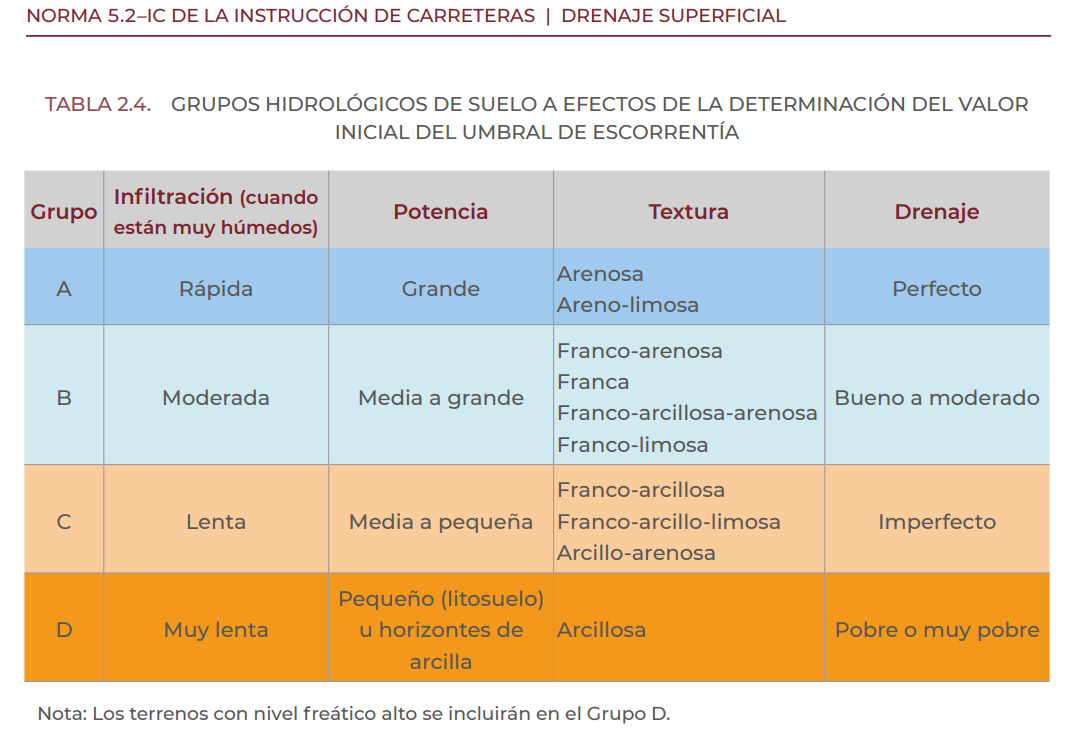

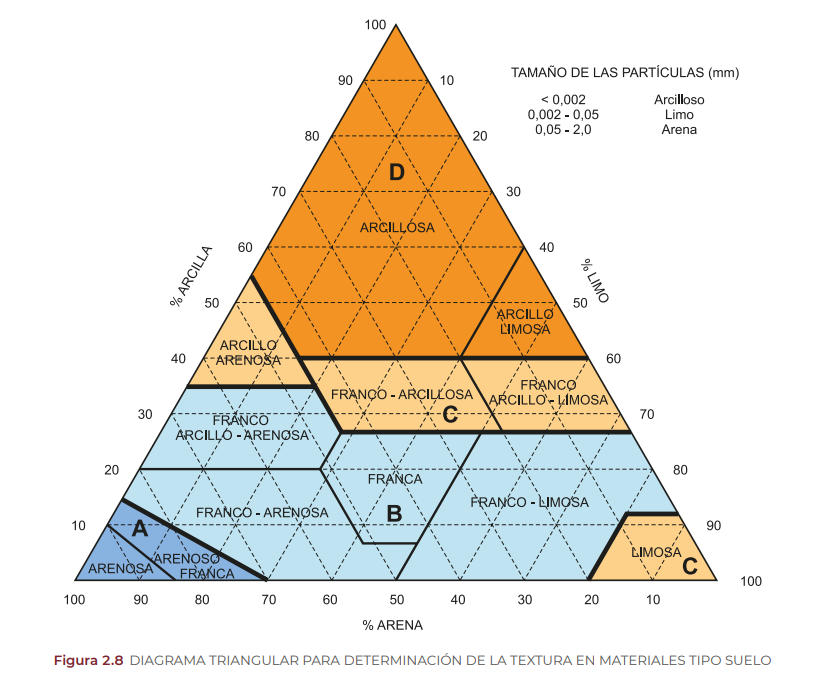

In [ ]:
# We create an array with the hydrological groups of the soil according to texture.
g_hidro = np.zeros(texture.shape)
g_hidro[(texture == 5) | (texture == 4)] = 1 # A
g_hidro[(texture == 7) | (texture == 8) | (texture == 3) | (texture == 12)] = 2 # B
g_hidro[(texture == 6) | (texture == 2) | (texture == 11) | (texture == 9)] = 3 # C
g_hidro[(texture == 1) | (texture == 10)] = 4 # D
g_hidro[(texture == 0)] = 0 # D / Water
g_hidro

array([[3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       ...,
       [3., 3., 2., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [ ]:
# The variables needed to read and operate the raster are initialised.
opath = "./soils/groups_hydro.tif"
ipath = "./soils/clay_0-5cm_mean.tif"
with rasterio.open(opj(ipath)) as src:
    metadata =  src.meta.copy()
with rasterio.open(opath, 'w', **metadata) as dst:
    # Write the data to the new GeoTIFF file
    dst.write(g_hidro, 1)
src.close()
dst.close()
print(''.join(['File created: ', opath]))

File created: ./soils/groups_hydro.tif


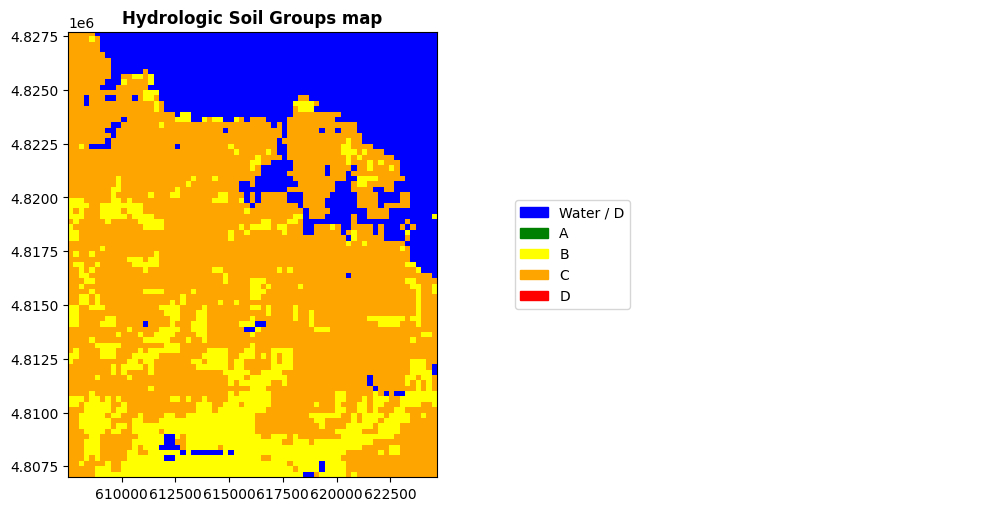

In [ ]:
# Open the raster file
raster_path =  "./soils/groups_hydro.tif"
src = rasterio.open(raster_path)
# Define your custom colormap with 12 colors
colors = ['blue', 'green', 'yellow', 'orange', 'red']
cmap = ListedColormap(colors, name='custom_colormap', N=4)

    # Plot the raster using rasterio's show function with the custom colormap
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    # Add a colorbar for the raster values
ax_1 =  axes[0]
ax_1 = rasplot.show(src, ax=ax_1, title='Hydrologic Soil Groups map', cmap=cmap, vmin=0, vmax=4);

ax_2 =  axes[1]
ax_2.axis('off')
    # Create a legend for the classes
legend_labels = ['Water / D', 'A', 'B', 'C', 'D']
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax_2.legend(handles=legend_patches, loc='center left');
    # Show the plot
src.close()

### We check that the definitions have been made correctly at random points.

In [ ]:
# Check the raster size 'cause it's possible that some of the ramdom points defined were out of the raster
print(clay.shape)

(83, 69)


In [ ]:
### We check the results
columnas =  ['row', 'col', 'clay [%]', 'sand [%]', 'silt [%]', 'USDA_Texture', 'HydroSoilGroup']
rev = pd.DataFrame(columns=columnas)
puntos_rev = [[0,0], [180, 208], [60, 100], [20,50], [135,136], [54, 68]]
text_labels = ['No data / Water surface', 'Clay', 'Clay loam', 'Loam', 'Loamy sand', 'Sand', 'Sandy clay',
                 'Sandy clay loam', 'Sandy loam', 'Silt', 'Silt clay', 'Silt clay loam', 'Silt loam']
gh_labels = ['Water surface', 'A', 'B', 'C', 'D']
for p in puntos_rev:
    text_num = texture[p[0],p[1]]
    text = text_labels[int(text_num)]
    gh_num = g_hidro[p[0],p[1]]
    gh = gh_labels[int(gh_num)]
    new_row = {'row':p[0], 'col':p[1],'clay [%]':clay[p[0], p[1]], 'sand [%]': sand[p[0], p[1]], 'silt [%]': silt[p[0],p[1]], 'USDA_Texture': ''.join([text, ': ', str(text_num)]), 'HydroSoilGroup':''.join([gh, ': ', str(gh_num)])}
    rev.loc[len(rev)] = new_row
rev

,row,col,clay [%],sand [%],silt [%],Textura,Grupo_hidro
0,0,0,26.880,35.275,37.865,Franca: 3.0,B: 2.0
1,180,208,35.055,24.870,40.075,Franco arcillosa: 2.0,C: 3.0
2,60,100,25.855,32.530,41.630,Franca: 3.0,B: 2.0
3,20,50,24.560,35.435,39.980,Franca: 3.0,B: 2.0
4,135,136,30.100,31.235,38.705,Franco arcillosa: 2.0,C: 3.0
5,54,68,27.100,34.250,38.635,Franco arcillosa: 2.0,C: 3.0


### Reproject


In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3035'

with rasterio.open("./soils/groups_hydro.tif") as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./soils/groups_hydro_EPSG_25830.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

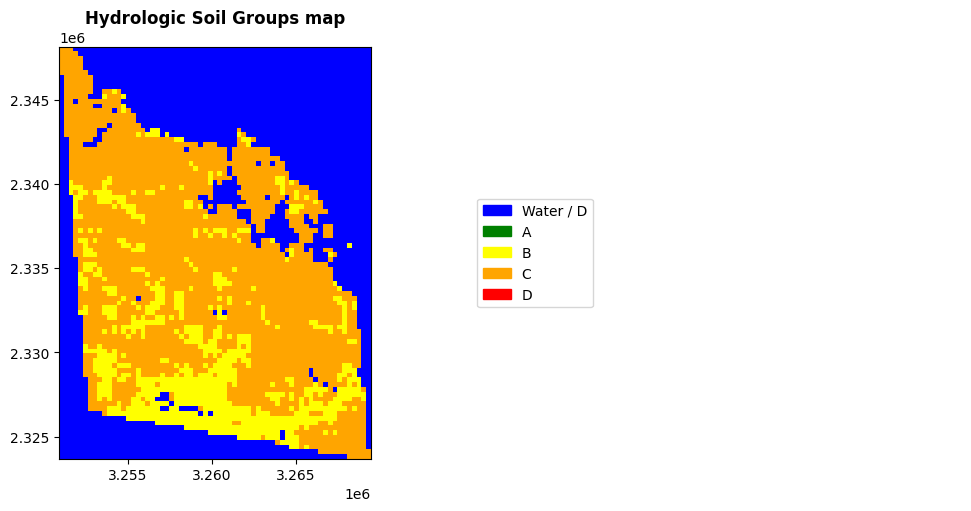

In [ ]:
# Open the raster file
raster_path =  './soils/groups_hydro_EPSG_25830.tif'
src = rasterio.open(raster_path)
# Define your custom colormap with 12 colors
colors = ['blue', 'green', 'yellow', 'orange', 'red']
cmap = ListedColormap(colors, name='custom_colormap', N=4)

    # Plot the raster using rasterio's show function with the custom colormap
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    # Add a colorbar for the raster values
ax_1 =  axes[0]
ax_1 = rasplot.show(src, ax=ax_1, title='Hydrologic Soil Groups map', cmap=cmap, vmin=0, vmax=4);

ax_2 =  axes[1]
ax_2.axis('off')
    # Create a legend for the classes
legend_labels = ['Water / D', 'A', 'B', 'C', 'D']
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax_2.legend(handles=legend_patches, loc='center left');
    # Show the plot
src.close()

### Clip the basin

In [ ]:
### Clip to basin shape
from rasterio import plot
from rasterio.mask import mask

opath = 'HydroSoilGroups_Ason.tif'

# Leemos el raster
with rasterio.open('./soils/groups_hydro_EPSG_25830.tif') as mdt_zona:
    # Usamos el shapefile de la todas las subcuencas como mascara
    out_image, out_transform = mask(mdt_zona, quad_with_basin.geometry, all_touched=True, nodata=-1, crop=True)

    # Copiamos la metadata
    out_meta = mdt_zona.meta.copy()

# Actualizamos la metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
# Creamos un fichero .tif con el raster cortado
with rasterio.open(opath, "w", **out_meta) as mdt_qnk:
    mdt_qnk.write(out_image)
mdt_zona.close()
mdt_qnk.close()

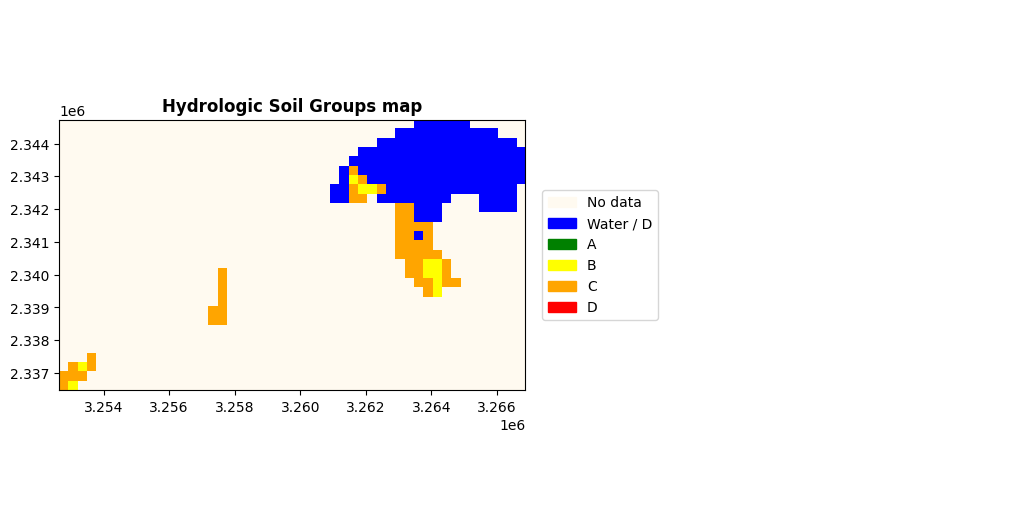

In [ ]:
# Open the raster file
raster_path =  'HydroSoilGroups_Ason.tif'
src = rasterio.open(raster_path)
# Define your custom colormap with 12 colors
colors = ['floralwhite','blue', 'green', 'yellow', 'orange', 'red']
cmap = ListedColormap(colors, name='custom_colormap', N=6)

    # Plot the raster using rasterio's show function with the custom colormap
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')
    # Add a colorbar for the raster values
ax_1 =  axes[0]
ax_1 = rasplot.show(src, ax=ax_1, title='Hydrologic Soil Groups map', cmap=cmap, vmin=-1, vmax=4);

ax_2 =  axes[1]
ax_2.axis('off')
    # Create a legend for the classes
legend_labels = ['No data','Water / D', 'A', 'B', 'C', 'D']
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
ax_2.legend(handles=legend_patches, loc='center left');
    # Show the plot
src.close()

### Vectorise

In [ ]:
# Open the raster file
raster_path =  'HydroSoilGroups_Ason.tif'
src = rasterio.open(raster_path)
raster_data = src.read(1)
print(raster_data.max())
print(raster_data.min())
print(np.unique(raster_data))

3
-1
[-1  0  2  3]


In [ ]:
# Import the hydrologic soil groups map
raster_path =  'HydroSoilGroups_Ason.tif'
raster_src = rasterio.open(raster_path)
# Read raster data
raster_data = raster_src.read(1)
mask_basin = raster_data != -1
# Generate shapes from the raster data
vector_features = list(rasterio.features.shapes(raster_data, mask=mask_basin, connectivity=8, transform=raster_src.transform))
# Create a GeoDataFrame
HSG_vec = gpd.GeoDataFrame(({'geometry': [shape(geometry) for geometry, value in vector_features], 'value': [value for geometry, value in vector_features]}), crs=quad_with_basin.crs)
raster_src.close()
# Change the data type
HSG_vec.loc[:,'HGS_digits'] = HSG_vec.loc[:,'value'].astype(int)
HSG_vec.loc[:,'HGS_digits'] = HSG_vec.loc[:,'HGS_digits'] * 10000;
HSG_vec.loc[:,'Code_HGS'] = HSG_vec.loc[:,'HGS_digits'].astype(str)
### drop value column ###
HSG_vec = HSG_vec.drop('value', axis=1)

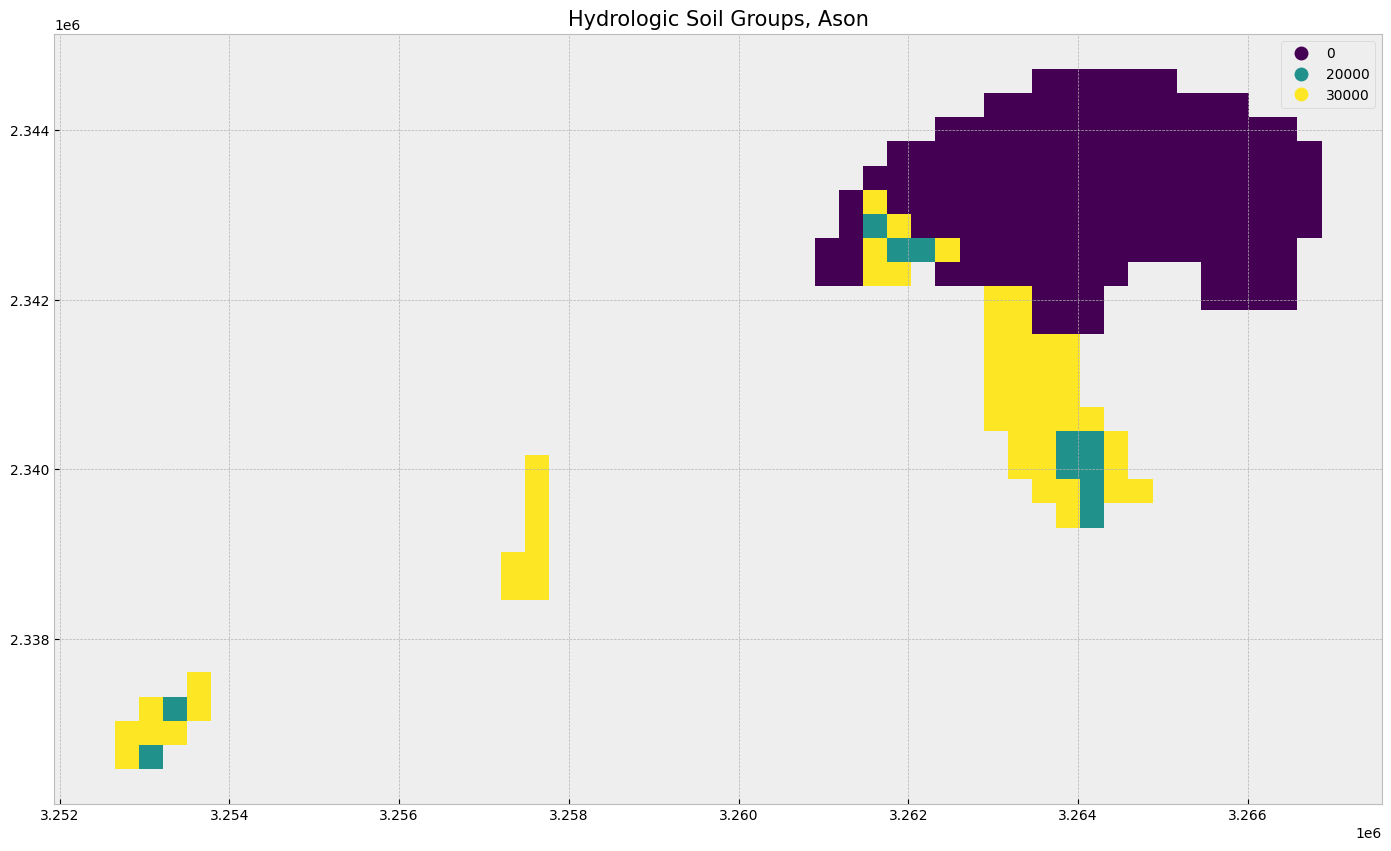

In [ ]:
# Plot to visualise
plt.style.use('bmh') #
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
HSG_vec.plot(ax=ax, column='Code_HGS', cmap='viridis', label='Code_HGS', linewidth=0.5, legend = True)
ax.set_title('Hydrologic Soil Groups', fontdict = {'fontsize': '15', 'fontweight' : '3'});
# Show the plot
plt.show()

In [ ]:
HSG_vec

,geometry,HGS_digits,Code_HGS
0,"POLYGON ((3263456.541 2344719.576, 3265163.173...",0,0
1,"POLYGON ((3261465.471 2343297.383, 3261749.910...",30000,30000
2,"POLYGON ((3261465.471 2343012.945, 3261465.471...",20000,20000
3,"POLYGON ((3262318.787 2342728.506, 3262318.787...",30000,30000
4,"POLYGON ((3263456.541 2341306.313, 3263456.541...",0,0
5,"POLYGON ((3262887.664 2342159.629, 3262887.664...",30000,30000
6,"POLYGON ((3263740.980 2340452.997, 3263740.980...",20000,20000
7,"POLYGON ((3257483.331 2340168.559, 3257767.770...",30000,30000
8,"POLYGON ((3253501.191 2337608.612, 3253785.630...",30000,30000
9,"POLYGON ((3253216.753 2337324.173, 3253216.753...",20000,20000
